##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# [Neural Machine Translation with Attention](https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/r2/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation using [tf.keras](https://www.tensorflow.org/programmers_guide/keras) and [eager execution](https://www.tensorflow.org/programmers_guide/eager). This is an advanced example that assumes some knowledge of sequence to sequence models.

> このノートブックは [tf.keras](https://www.tensorflow.org/programmers_guide/keras) と [eager exicution](https://www.tensorflow.org/programmers_guide/eager) を使用してスペイン語を英語に翻訳するシーケンス to シーケンス（seq2seq）モデルを学習します。これはシーケンス to シーケンスモデルに関する知識を前提とした高度な例です。

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"* , and return the English translation: *"are you still at home?"*

> このノートブックでモデルを訓練した後は *"¿todavia estan en casa?"* などのスペイン語の文章を入力して、英語の翻訳 *"are you still at home?"* を返すことができます。

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

> 翻訳の質は例題としては妥当ですが、生成された Attention プロットはおそらくもっと興味深いものです。これは翻訳中に入力文のどの部分にモデルが注目したかを示します。

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 mintues to run on a single P100 GPU.

> 注：この例では1台のP100 GPUで実行するのに約10分かかります。

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

# Import TensorFlow >= 1.10 and enable eager execution
!pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
# tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

print(tf.__version__)

     |████████████████████████████████| 348.9MB 91kB/s 
     |████████████████████████████████| 3.1MB 41.4MB/s 
     |████████████████████████████████| 501kB 50.7MB/s 
2.0.0-beta1


In [0]:
from typing import List, Dict, Sequence, Tuple, Iterable

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

> http://www.manythings.org/anki/ で提供されている言語データセットを使用します。このデータセットには次の形式の言語翻訳ペアが含まれています。

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

> さまざまな言語がありますが、ここでは英語 - スペイン語のデータセットを使用します。便宜上、このデータセットのコピーをGoogle Cloudでホストしていますが、自分のコピーをダウンロードすることもできます。データセットをダウンロードした後、データを準備するための手順は次のとおりです。

1. Add a *start* and *end* token to each sentence.<br />各文に開始トークンと終了トークンを追加します。
2. Clean the sentences by removing special characters.<br />特殊文字を削除して文章をきれいにします。
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).<br />単語インデクスと逆単語インデクスを作成します（単語→id と id→単語 のマッピング辞書）。
4. Pad each sentence to a maximum length.<br />各文を最大長まで埋めます。

In [0]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org'
        '/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip) + '/spa-eng/spa.txt'

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w: str) -> str:
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931
    #     /python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
en_sentence = 'May I borrow this book?'
sp_sentence = '¿Puedo tomar prestado este libro?'
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: zip[ENGLISH(Tuple), SPANISH(Tuple)]
def create_dataset(path: str, num_examples: int) -> zip:
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [
        [preprocess_sentence(w) for w in l.split('\t')]
        for l in lines[:num_examples]
    ]
    
    return zip(*word_pairs)

In [0]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(
    lang: Sequence[str]
) -> Tuple[np.ndarray, tf.keras.preprocessing.text.Tokenizer]:
    
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor,
        padding='post')

    return tensor, lang_tokenizer

> [Tokenizer](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/text/Tokenizer)
> <br />
> [pad_sequences](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)

In [0]:
def load_dataset(path: str, num_examples: int = None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

> 10万文を超える完全なデータセットのトレーニングには長い時間がかかります。より早く訓練するために、データセットのサイズを3万文に制限することができます（もちろん少ないデータでは翻訳品質が低下します）。

In [0]:
# Try experimenting with the size of that dataset
num_examples = None  # 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(
    path_to_file,
    num_examples)

# Calculate max_length of the input tensors and the target tensors
max_length_inp = max_length(input_tensor)
max_length_targ = max_length(target_tensor)

In [0]:
# Creating training and validation sets using an 80-20 split
(input_tensor_train, input_tensor_val,
 target_tensor_train, target_tensor_val) = train_test_split(
    input_tensor,
    target_tensor,
    test_size=0.2)

# Show length
(len(input_tensor_train), len(target_tensor_train),
 len(input_tensor_val), len(target_tensor_val))

(95171, 95171, 23793, 23793)

In [0]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, lang.index_word[t]))

In [0]:
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
2188 ----> ponte
6 ----> el
682 ----> sombrero
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
175 ----> put
35 ----> your
698 ----> hat
36 ----> on
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

> [from_tensor_slices](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#from_tensor_slices)

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 53]), TensorShape([64, 51]))

## Write the encoder and decoder model

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input word is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

> ここでは TensorFlow [Neural Machine Translation(seq2seq) チュートリアル](https://github.com/tensorflow/nmt)で読むことができる、Attention付きエンコーダー - デコーダーモデルを実装します。この例ではより新しい一連の API を使用しています。このノートブックは seq2seq チュートリアルから [Attention 計算式](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism)を実装します。次の図は、各入力単語に Attention メカニズムによって重みが割り当てられていることを示しています。このメカニズムは文章内の次の単語を予測するためにデコーダーによって使用されます。

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*. 

> 入力はエンコーダーモデルを通過します。これにより形状が  *(batch_size, max_length, hidden_size)* のエンコーダー出力と、形状が *(batch_size, hidden_size)* のエンコーダー隠れ状態が得られます。

Here are the equations that are implemented:

> これが実装される計算式です：

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using [*Bahdanau attention*](https://arxiv.org/pdf/1409.0473.pdf). Lets decide on notation before writing the simplified form:

> 私たちは [*Bahdanau attention*](https://arxiv.org/pdf/1409.0473.pdf) を使います。簡略形で書く前に表記法を決めましょう。

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

>そして擬似コードです。

* `score = FC(tanh(FC(EO) + FC(H)))`<br />
> メモ：全結合層は入力と内部の重みの行列積を計算するレイヤーのため、計算式中で $W_1$ や $v_a$ などの重みとの積の部分は `FC` により表現できる。ここで $h_t$ = `H`、$\bar{h}_s$ = `EO` 。
* `attention weights = softmax(score, axis = 1)`<br />
Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, 1)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.<br />
Softmax はデフォルトでは最後の軸に適用されますが、ここではスコアの形状が *(batch_size, max_length, 1)* であるため、*1番目の軸* に適用します。 `Max_length` は私達の入力の長さです。各入力に重みを割り当てようとしているので softmax をその軸に適用する必要があります。
* `context vector = sum(attention weights * EO, axis = 1)`<br />
Same reason as above for choosing axis as 1.<br />1番目の軸を選択したのは上と同じ理由です。
* `embedding output` = The input to the decoder X is passed through an embedding layer.<br />デコーダーへの入力 X は埋め込み層を通過します。
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU<br />このマージされたベクトルは GRU に渡されます
  
The shapes of all the vectors at each step have been specified in the comments in the code:

> 各ステップのすべてのベクトルの形状はコード内のコメントで指定されています。

In [0]:
class Encoder(tf.keras.Model):
    def __init__(
            self,
            vocab_size: int,  # 語彙数
            embedding_dim: int,  # 埋め込みレイヤーで出力する密ベクトルの次元数
            enc_units: int,  # Encoder(のGRU）の出力次元数
            batch_sz: int):  # バッチサイズ

        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform')

    # 入力 x は int の ndarray を convert_to_tensor() したもの
    # 型としては tensorflow.python.framework.ops.EagerTensor …
    # hidden は初回は initialze_hidden_state で返却したものが渡ってくる
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

> [Embedding](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Embedding)
> <br />
> <br />Embedding レイヤーは入力の整数値（単語ID）を固定長の密ベクトルに変換する。第1引数 input_dim は語彙数。第2引数 output_dim は出力する密ベクトルの次元数。

> [GRU](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/GRU)
> <br />
> <br />※GPUが使われる条件について抜粋※
> <br />利用可能なランタイムハードウェアと制約に基づいて、このレイヤーはパフォーマンス最大化のため異なる実装（cuDNNベースまたは純粋なTensorFlow）を選択します。 GPUが利用可能で、レイヤーに対するすべての引数がCuDNNカーネルの要件を満たす場合（詳細は下記を参照）、高速なcuDNN実装を使用します。
> <br />
> <br />cuDNN実装を使用するための要件は次のとおりです。
> <br />
> 1. activation == 'tanh'
> 1. recurrent_activation == 'sigmoid'
> 1. recurrent_dropout == 0
> 1. unroll is False
> 1. use_bias is True
> 1. reset_after is True
> 1. 入力がマスクされていないか、厳密に右詰めされている
> <br />メモ：1 ～ 6 は既定値のため、この入力値の条件さえ満たせば GPU が使われる

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) '
      f'{sample_output.shape}')
print('Encoder Hidden state shape: (batch size, units) '
      f'{sample_hidden.shape}')

Encoder output shape: (batch size, sequence length, units) (64, 53, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is
        # (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [0]:
class Decoder(tf.keras.Model):
    def __init__(
        self,
        vocab_size: int,  # 語彙数
        embedding_dim: int,  # 埋め込みレイヤーで出力する密ベクトルの次元数
        dec_units: int,  # GRU の出力次元数
        batch_sz: int):  # バッチサイズ

        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.dec_units,
            return_sequences=True,  # 入力の全単語分の出力を返す
            return_state=True,  # 隠れ状態を返す
            recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding ==
        # (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == 
        # (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(
    tf.random.uniform((BATCH_SIZE, 1)),
    sample_hidden,
    sample_output)

print('Decoder output shape: (batch_size, vocab size) '
      f'{sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (64, 12934)


## Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

> [Adam](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers/Adam)
> <br />
> [SparseCategoricalCrossentropy](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
> <br />
> [sparse_softmax_cross_entropy_with_logits](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits)

## Checkpoints (Object-based saving)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    optimizer=optimizer,
    encoder=encoder,
    decoder=decoder)

> [Checkpoint](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/train/Checkpoint)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
<br />出力と隠れ状態を返すエンコーダーに入力を渡します。
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
<br />エンコーダーの出力と隠れ状態、およびデコーダー入力（開始トークン）がデコーダーに渡されます。
3. The decoder returns the *predictions* and the *decoder hidden state*.
<br />デコーダーは予測結果とデコーダー隠れ状態を返します。
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
<br />デコーダー隠れ状態がモデルに戻され、予測結果が損失の計算に使用されます。
5. Use *teacher forcing* to decide the next input to the decoder.
<br />デコーダーへの次の入力を決定するために *teacher forcing* を使用します。
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
<br />*Teacher forcing* は目標（正解）の単語を次の入力としてデコーダーに渡す手法です。
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.
<br />最後のステップは勾配を計算し、それをオプティマイザーに適用して逆伝播することです。

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims(
            [targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(
                dec_input,
                dec_hidden,
                enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} '
                  f'Loss {batch_loss.numpy():.4f}')

    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print(f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start} sec\n')

Epoch 1 Batch 0 Loss 1.5141
Epoch 1 Batch 100 Loss 0.8705
Epoch 1 Batch 200 Loss 0.8319
Epoch 1 Batch 300 Loss 0.7555
Epoch 1 Batch 400 Loss 0.6828
Epoch 1 Batch 500 Loss 0.6278
Epoch 1 Batch 600 Loss 0.7035
Epoch 1 Batch 700 Loss 0.5597
Epoch 1 Batch 800 Loss 0.6325
Epoch 1 Batch 900 Loss 0.5772
Epoch 1 Batch 1000 Loss 0.5945
Epoch 1 Batch 1100 Loss 0.5523
Epoch 1 Batch 1200 Loss 0.5225
Epoch 1 Batch 1300 Loss 0.5209
Epoch 1 Batch 1400 Loss 0.5135
Epoch 1 Loss 0.6386
Time taken for 1 epoch 1195.2051565647125 sec

Epoch 2 Batch 0 Loss 0.4638
Epoch 2 Batch 100 Loss 0.4154
Epoch 2 Batch 200 Loss 0.4725
Epoch 2 Batch 300 Loss 0.4313
Epoch 2 Batch 400 Loss 0.3725
Epoch 2 Batch 500 Loss 0.3484
Epoch 2 Batch 600 Loss 0.4036
Epoch 2 Batch 700 Loss 0.3237
Epoch 2 Batch 800 Loss 0.3503
Epoch 2 Batch 900 Loss 0.3102
Epoch 2 Batch 1000 Loss 0.3135
Epoch 2 Batch 1100 Loss 0.2782
Epoch 2 Batch 1200 Loss 0.2917
Epoch 2 Batch 1300 Loss 0.2927
Epoch 2 Batch 1400 Loss 0.3001
Epoch 2 Loss 0.3462
Time ta

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
<br />評価関数は *teacher forcing* を使用しないことを除いてトレーニングループと似ています。各時間ステップのデコーダーへの入力は、1つ前の予測値および隠れ状態とエンコーダー出力です。
* Stop predicting when the model predicts the *end token*.
<br />モデルが終了トークンを予測したら予測を停止します。
* And store the *attention weights for every time step*.
<br />そしてタイムステップごとに attention weights を保存します。

Note: The encoder output is calculated only once for one input.

> 注：エンコーダー出力は1つの入力に対して1回だけ計算されます。

In [0]:
def evaluate(sentence):

    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences(
        [inputs],
        maxlen=max_length_inp,
        padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(
            dec_input,
            dec_hidden,
            enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 11}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence):

    result, sentence, attention_plot = evaluate(sentence)
        
    print(f'Input: {sentence}')
    print(f'Predicted translation: {result}')
    
    attention_plot = attention_plot[
        :len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


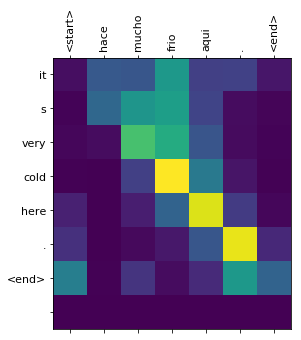

In [0]:
translate('hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


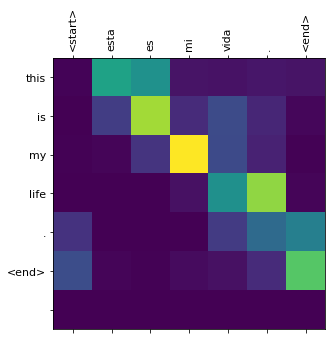

In [0]:
translate('esta es mi vida.')

Input: <start> todavia estan en casa ? <end>
Predicted translation: they re still at home . <end> 


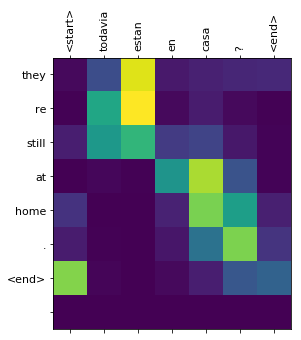

In [0]:
translate('todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it . <end> 


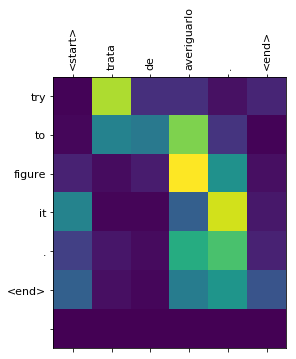

In [0]:
# wrong translation
translate('trata de averiguarlo.')

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
<br />[別のデータセットをダウンロード](http://www.manythings.org/anki/)して、たとえば英語からドイツ語、または英語からフランス語への翻訳を試してください。
* Experiment with training on a larger dataset, or using more epochs
<br />より大きなデータセットでのトレーニング、またはより多くのエポックの使用を試してください。